# **ML Final Project**
### 1971063 김윤서   

• Task 1: Implement Inception module for CIFAIR-10. (20 points)    
• Task 2: Increase your Test set accuracy. (25 points)    
• Task 3: Find hyper-parameters. (25 points)    
• Task 4: Write report: (30 points)


## 0. CIFAR10 데이터셋 불러오기

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

 #train data 용도
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,   
                                        download=True, transform=transform) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size= 8,          #hyper-parameter: batch_size=8
                                          shuffle=True, num_workers=2)
  
  #test data 용도
testset = torchvision.datasets.CIFAR10(root='./data', train=False,    
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size= 8,            #hyper-parameter: batch_size=8
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [14]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


## 1. 필요한 함수 정의

#### print_accuracy 함수: 모델 정확도 출력

In [15]:
def print_accuracy(net, dataloader):
    correct = 0
    total = 0

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            # Inference on GPU
            images = images.to(device)
            labels = labels.to(device)
        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    print('Accuracy of the network on the %d test images: %d %%' 
          % (total, 100 * correct / total))

#### train_val 함수

In [16]:
def metric_batch(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects



def loss_batch(loss_func, outputs, target, opt=None):
    if np.shape(outputs)[0] == 3:
        output, aux1, aux2 = outputs

        output_loss = loss_func(output, target)
        aux1_loss = loss_func(aux1, target)
        aux2_loss = loss_func(aux2, target)

        loss = output_loss + 0.3*(aux1_loss + aux2_loss)
        metric_b = metric_batch(output,target)

    else:
        loss = loss_func(outputs, target)
        metric_b = metric_batch(outputs, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    
    return loss.item(), metric_b



def loss_epoch(model, loss_func, dataset_dl, opt=None):
    running_loss = 0.0
    running_metric = 0.0
    len_data = len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        xb = xb.to(device)
        yb = yb.to(device)
        output= model(xb)

        loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

        running_loss += loss_b

        if metric_b is not None:
            running_metric += metric_b

    loss = running_loss / len_data
    metric = running_metric / len_data

    return loss, metric



def train_val(model, params):
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]

    loss_history = {'train': [], 'val': []}
    metric_history = {'train': [], 'val': []}

    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        
        model.train()
        train_loss, train_metric = loss_epoch(model, loss_func, train_dl, opt)
        loss_history['train'].append(train_loss)
        metric_history['train'].append(train_metric)

        model.eval()
        with torch.no_grad():
            val_loss, val_metric = loss_epoch(model, loss_func, val_dl)

        loss_history['val'].append(val_loss)
        metric_history['val'].append(val_metric)

        print('train loss: %.6f, val loss: %.6f, accuracy: %.2f' %(train_loss, val_loss, 100*val_metric))
        print('-'*10)

    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

#### 시각화 함수: learning curve 그리기

In [26]:

import matplotlib.pyplot as plt

def plot_acc(history, title=None):
  # summarize history for accuracy
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['train'])         # train 데이터로 구한 정확도값
  plt.plot(history['val'])     # test 데이터로 구한 정확도값
  if title is not None:
    plt.title(title)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Test'], loc=0)   # 두 선의 이름(Train, Test) 표시

def plot_loss(history, title=None):
  # summarize history for loss
  if not isinstance(history, dict):
    history = history.history
  plt.plot(history['train'])             # train 데이터로 구한 손실값
  plt.plot(history['val'])         # test 데이터로 구한 손실값
  if title is not None:
    plt.title(title)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Test'], loc=0)

+ 데이터셋 확인해보기

## 2. Inception module 정의


In [18]:
class Inception(nn.Module):
    def __init__(self, in_planes, n1x1, n3x3red, n3x3, n5x5red, n5x5, pool_planes):
        super(Inception, self).__init__()
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, n1x1, kernel_size=1),
            nn.BatchNorm2d(n1x1),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, n3x3red, kernel_size=1),
            nn.BatchNorm2d(n3x3red),
            nn.ReLU(True),
            nn.Conv2d(n3x3red, n3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(n3x3),
            nn.ReLU(True),
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, n5x5red, kernel_size=1),
            nn.BatchNorm2d(n5x5red),
            nn.ReLU(True),
            nn.Conv2d(n5x5red, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
            nn.Conv2d(n5x5, n5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(n5x5),
            nn.ReLU(True),
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1,y2,y3,y4], 1)

## 3. CNN 모델 정의 
#### Training setup:
* Loss function: Sotfmax cross entropy
* Optimizer: Gradient descent with 0.001 learning rate
* Batch size: 4
* Training epoch: 2


In [19]:
# Training on GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 모델 1: GoogleNet

### 모델 2: GoogleNet 보완해보기 -> MyNet

In [20]:

class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()

        self.pre_layers = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),  #hyper-Parameter: filter size = 3
            nn.BatchNorm2d(128),
            nn.ReLU(True),        #활성화 함수 ReLU 사용
        )

        self.a3 = Inception(128,  32,  48,  64,  8, 16, 16)
        self.b3 = Inception(128,  64,  96, 128, 16, 32, 32)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a4 = Inception(256, 160,  96, 256, 16,  64,  64)
        self.b4 = Inception(544, 256, 128, 256, 64, 128, 128)
        self.c4 = Inception(768, 256, 128, 256, 64, 128, 128)

        self.maxpool = nn.MaxPool2d(3, stride=2, padding=1)

        self.a5 = Inception(768, 256, 256, 512, 64, 128, 128)
        self.b5 = Inception(1024, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(8, stride=1)  # Average Pooling 사용
        self.linear = nn.Linear(1024, 10)
        

    def forward(self, x):
        
        out = self.pre_layers(x)
        out = self.a3(out)
        out = self.b3(out)
        out = self.maxpool(out)
        out = self.a4(out)
        out = self.b4(out)
        out = self.c4(out)
        out = self.maxpool(out)
        out = self.a5(out)
        out = self.b5(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        
        return out

In [21]:

myNet = MyNet()
myNet = myNet.to(device)

# Define a Loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(myNet.parameters(), lr=0.001, momentum=0.9)

PATH = './my_net.pth'
epochs = 6


In [22]:
params_train = {
    'num_epochs':epochs,
    'optimizer':optimizer,
    'loss_func':loss_func,
    'train_dl':trainloader,
    'val_dl':testloader
}


In [23]:

myNet, loss_hist, metric_hist = train_val(myNet, params_train)


train loss: 0.146752, val loss: 0.089665, accuracy: 75.39
----------
train loss: 0.086928, val loss: 0.063040, accuracy: 82.88
----------
train loss: 0.065011, val loss: 0.055650, accuracy: 84.99
----------
train loss: 0.050329, val loss: 0.052089, accuracy: 85.64
----------
train loss: 0.039856, val loss: 0.050668, accuracy: 86.46
----------
train loss: 0.031717, val loss: 0.049372, accuracy: 87.23
----------


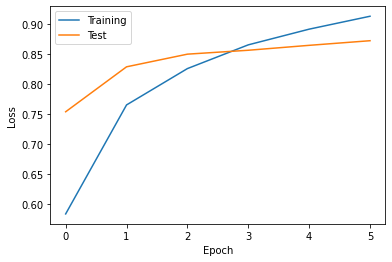

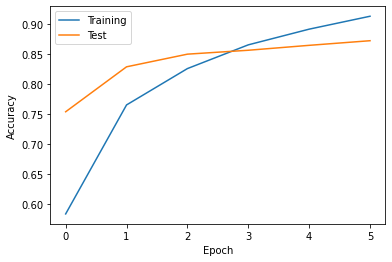

In [27]:
plot_loss(metric_hist)
plt.show()

plot_acc(metric_hist)
plt.show()

In [25]:
print_accuracy(myNet, testloader)

Accuracy of the network on the 10000 test images: 87 %


## * hyper-parameter 목록
1. **learning rate** (lr)=0.001, 0.0005, 0.0001, ...   
2. **Batch size**=4,8,16,32   
3. **Epochs**=2,4,6 ...
4. Network architectures: googLeNet
5. Activation functions: RELU 사용   
6. Loss function: Sotfmax cross entropy   